In [1]:
# code adapted from these two sites:
# https://debuggercafe.com/convolutional-variational-autoencoder-in-pytorch-on-mnist-dataset/
# https://medium.com/@nutanbhogendrasharma/pytorch-convolutional-neural-network-with-mnist-dataset-4e8a4265e118
import pickle
from sklearn.model_selection import train_test_split
import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
bs = 256

with open('PS_v2_32.pkl','rb') as f:
    PS = pickle.load(f)

PS = [(1-p[0],p[1]) for p in PS]
ds_train, ds_val = train_test_split(PS,test_size=.1,random_state=4)
train_loader = torch.utils.data.DataLoader(dataset=ds_train, batch_size=bs, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=ds_val, batch_size=bs, shuffle=False)

In [3]:
# return reconstruction error + KL divergence losses
def loss_function(recon_x, x, mu, log_var):
    #BCE = F.binary_cross_entropy(recon_x, x.view(-1, 32*32), reduction='sum')
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

def train(epoch,verbose_step):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.cuda()
        optimizer.zero_grad()

        recon_batch, mu, log_var = vae(data)
        loss = loss_function(recon_batch, data, mu, log_var)

        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    if epoch % verbose_step == 0:
        print('epoch: {} train loss: {:.2f}'.format(epoch, train_loss / len(train_loader.dataset)),end=' ')

def val(epoch):
    vae.eval()
    val_loss= 0
    val_error = []
    with torch.no_grad():
        for data, _ in val_loader:
            data = data.cuda()
            recon, mu, log_var = vae(data)

            val_loss += loss_function(recon, data, mu, log_var).item()

            data = data.detach().cpu().numpy()
            diff = np.abs(data-recon.detach().cpu().numpy())
            val_error.append(np.mean(np.mean(diff[:,0],axis=-1),axis=-1))

    val_loss /= len(val_loader.dataset)
    val_error = np.mean(np.concatenate(val_error))
    print('val loss: {:.2f}'.format(val_loss),
          'val error: {:.3f}'.format(val_error), end=' ')
    return val_error

def rowplot(t):
    N = t.shape[0]
    with torch.no_grad():
        r = vae(t.cuda())[0].view(N, 32,32).detach().cpu().numpy()

    fig, axs = plt.subplots(1,2*N, figsize=(5, 5))

    for n in range(N):
        a=axs[2*n]
        a.imshow(1-t[n][0],cmap='gray')
        a.axis('off')
        b=axs[2*n+1]
        b.imshow(1-r[n],cmap='gray')
        b.axis('off')
    plt.show()

def save_best(epoch, val_error, best_error):
    if epoch>0 and val_error < best_error:
        torch.save(vae.state_dict(),'vae.pt')
        print('saving model')
        best_error = val_error
    return best_error

In [4]:
class ConvVAE(nn.Module):
    def __init__(self, init_channels, final_channels, latent_dim, hidden_dim):
        super(ConvVAE, self).__init__()
        image_channels = 1 # images are grayscale
        kernel_size = 4 # (4, 4) kernel
        self.init_channels = init_channels
        self.final_channels = final_channels
        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim

        # encoder
        self.enc1 = nn.Conv2d(
            in_channels=image_channels, out_channels=init_channels, kernel_size=kernel_size,
            stride=2, padding=1
        )
        self.enc2 = nn.Conv2d(
            in_channels=init_channels, out_channels=init_channels*2, kernel_size=kernel_size,
            stride=2, padding=1
        )
        self.enc3 = nn.Conv2d(
            in_channels=init_channels*2, out_channels=init_channels*4, kernel_size=kernel_size,
            stride=2, padding=1
        )
        self.enc4 = nn.Conv2d(
            in_channels=init_channels*4, out_channels=final_channels, kernel_size=kernel_size,
            stride=2, padding=0
        )
        # fully connected layers for learning representations
        self.fc1 = nn.Linear(final_channels, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_log_var = nn.Linear(hidden_dim, latent_dim)
        self.fc2 = nn.Linear(latent_dim, final_channels)
        # decoder
        self.dec1 = nn.ConvTranspose2d(
            in_channels=final_channels, out_channels=init_channels*8, kernel_size=kernel_size,
            stride=1, padding=0
        )
        self.dec2 = nn.ConvTranspose2d(
            in_channels=init_channels*8, out_channels=init_channels*4, kernel_size=kernel_size,
            stride=2, padding=1
        )
        self.dec3 = nn.ConvTranspose2d(
            in_channels=init_channels*4, out_channels=init_channels*2, kernel_size=kernel_size,
            stride=2, padding=1
        )
        self.dec4 = nn.ConvTranspose2d(
            in_channels=init_channels*2, out_channels=image_channels, kernel_size=kernel_size,
            stride=2, padding=1
        )
        if torch.cuda.is_available():
            self.cuda()

    def encoder(self, x):
        # encoding
        x = F.relu(self.enc1(x))
        x = F.relu(self.enc2(x))
        x = F.relu(self.enc3(x))
        x = F.relu(self.enc4(x))
        batch, _, _, _ = x.shape
        x = F.adaptive_avg_pool2d(x, 1).reshape(batch, -1)
        hidden = self.fc1(x)
        #hidden = torch.sigmoid(hidden)
        # get `mu` and `log_var`
        mu = self.fc_mu(hidden)
        log_var = self.fc_log_var(hidden)
        # get the latent vector through reparameterization
        return hidden, mu, log_var

    def sample(self, mu, log_var):
        std = torch.exp(0.5*log_var) # standard deviation
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        z = mu + (eps * std) # sampling
        z = self.fc2(z)
        z = z.view(-1, self.final_channels, 1, 1)
        return z

    def decoder(self, z):
        x = F.relu(self.dec1(z))
        x = F.relu(self.dec2(x))
        x = F.relu(self.dec3(x))
        reconstruction = torch.sigmoid(self.dec4(x))
        return reconstruction

    def forward(self, x):
        hidden, mu, log_var = self.encoder(x)
        z = self.sample(mu, log_var)
        reconstruction = self.decoder(z)
        return reconstruction, mu, log_var




vae = ConvVAE(init_channels = 16, # initial number of filters
              final_channels = 64,
              latent_dim = 64, # latent dimension for sampling
              hidden_dim = 128)


print('# parameters:',sum([np.prod(m.shape) for n,m in vae.named_parameters()]))

# parameters: 431569


epoch: 0 train loss: 562.72 val loss: 484.20 val error: 0.309 

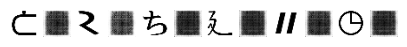

epoch: 20 train loss: 275.31 val loss: 281.97 val error: 0.145 saving model


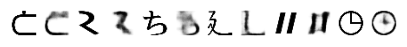

epoch: 40 train loss: 247.00 val loss: 261.99 val error: 0.129 saving model


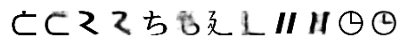

epoch: 60 train loss: 236.23 val loss: 259.00 val error: 0.124 saving model


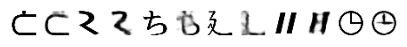

epoch: 80 train loss: 229.73 val loss: 257.99 val error: 0.120 saving model


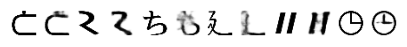

epoch: 100 train loss: 225.22 val loss: 259.23 val error: 0.121 

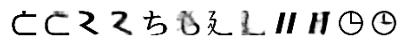

epoch: 120 train loss: 221.67 val loss: 258.42 val error: 0.119 saving model


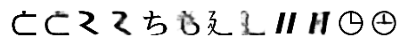

epoch: 140 train loss: 218.02 val loss: 258.54 val error: 0.115 saving model


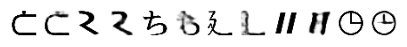

epoch: 160 train loss: 215.16 val loss: 260.55 val error: 0.115 saving model


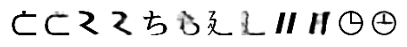

epoch: 180 train loss: 213.57 val loss: 259.79 val error: 0.113 saving model


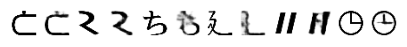

epoch: 200 train loss: 211.87 val loss: 262.59 val error: 0.112 saving model


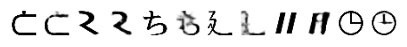

<All keys matched successfully>

In [5]:
verbose_step = 20
optimizer = torch.optim.AdamW(vae.parameters())
t = list(val_loader)[0][0][:6]

best_error = 1
for epoch in range(201):
    train(epoch,verbose_step)

    if epoch % verbose_step ==0:
        val_error = val(epoch)
        best_error = save_best(epoch, val_error, best_error)
        rowplot(t)
vae.load_state_dict(torch.load('vae.pt'))

In [6]:
# look at representation of letters
abcs = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
abct = torch.cat([[p for p in PS if p[1]==k][0][0] for k in abcs],dim=0).unsqueeze(1)
with torch.no_grad():
  r,_,_ = vae.encoder(abct.cuda())
r = r.detach().cpu().numpy()

for k,p in zip(abcs,r):
    print(k,''.join(['!' if i>0 else ' ' for i in p[:80]]))

A !       !!   ! !  !! !!! !!   ! ! !   !!   !!!         !! !!   !  !!      !  !!!
B ! ! !  ! !  !! ! ! ! !!!! !!   !! ! !!!!    !!!      !!!  !!!!!!   !!    !   !!!
C !!! ! ! !    !!! ! !!!  !!!!    ! ! !  ! !!  !!!! !  !   ! !!!!!    !  !      !!
D ! ! !  ! !  !! ! ! ! !  ! !  ! !! ! !! !      ! ! !  !!   ! !! !!  !    !     !!
E !!!!!  ! !   ! ! ! ! ! !! !!   !! !!!!!!!  !!!!   !  !!!  !!!!!!    ! !      !!!
F !!!!!  ! !! !! ! ! !!! !     ! !  !!!! !!! !!!!   !  !!!!  !! !!    ! !   !  ! !
G !!  ! !      !!!!! ! ! !  !!      ! ! !!    !!!!  !!  !! ! ! !!!!  !!  ! !!!  !!
H !!!!!       !! !  !!   ! !!! ! !!  !! !!!! !! ! !    !     !  !!!  !         ! !
I !! !   !!!     !  !! !!!!  !  !!  !  ! !     !    !! !!!! !!!! !  ! ! ! !!!! !!!
J !! !  ! !!!   !! !!!!!!!    ! !   !  ! ! !! !!!  !!!! !!! !! ! ! !  ! !! !!! !!!
K !! !!    !   ! !  !!!  ! !!!   !  !!  !!!! !!!!      ! !! !!  !!    !     !! !!!
L !!! !   !!   ! ! ! ! !!!!!!    !! !   !!!  !!!!   !  !!!  !!!!!!   !!      ! ! !
M   

In [7]:
# rank letters by reconstruction error
with torch.no_grad():
    r,_,_ = vae(abct.cuda())
r = r.detach().cpu().numpy()

diff = np.abs(r-abct.numpy())
diff = np.mean(np.mean(diff[:,0],axis=-1),axis=-1)
for k in np.argsort(diff):
    print(abcs[k],' ',np.round(diff[k],3))

I   0.013
T   0.014
L   0.014
O   0.016
U   0.019
Z   0.021
D   0.022
P   0.022
H   0.023
E   0.024
R   0.026
Y   0.027
F   0.03
B   0.03
C   0.03
K   0.034
G   0.035
V   0.037
A   0.039
X   0.04
J   0.043
S   0.045
N   0.048
W   0.086
Q   0.087
M   0.091


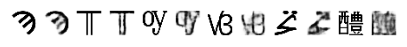

In [8]:
# check train vs val
rowplot(list(train_loader)[-1][0][:6])

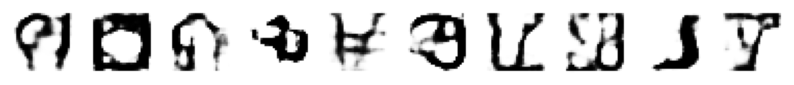

In [9]:
# generate random characters
N=10
m = torch.randn(N,vae.latent_dim).cuda()
v = torch.randn(N,vae.latent_dim).cuda()
z = vae.sample(m,v)

with torch.no_grad():
    sample = vae.decoder(z).cpu().detach().numpy()

if True:
    fig, axs = plt.subplots(1,N, figsize=(10, 5))

    for n in range(N):
        a=axs[n]
        a.imshow(1-sample[n,0],cmap='gray')
        a.axis('off')
    plt.show()